In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [2]:
#Loads up all the 70k images from the mnist dataset
mnist = fetch_openml('mnist_784',as_frame=False) 
#openml already splits data into a training set (first 60k) and a test set(last 10k)

In [3]:
X,y = mnist.data,mnist.target

In [4]:
print(X)
print(X.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)


In [5]:
print(y,y.shape)

['5' '0' '4' ... '4' '5' '6'] (70000,)


2


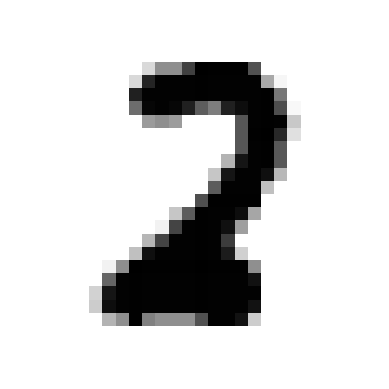

In [ ]:
def plot_digit(image_data):
    img= image_data.reshape(28,28)#Size of each image as there are 784 features in each of the 70k images
    plt.imshow(img,cmap="binary")
    plt.axis("off")
digit=X[0]
plot_digit(digit)
#This is what each image looks like from the data set
#for comparision 
print(y[7960])

In [7]:
#Extracting the pregiven test and train set
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [8]:
#Training a BINARY CLASSIFIER   
y_train_5= (y_train=='5') #True for all 5s ,False for all other digits
y_test_5 = (y_test == '5')

In [9]:
from sklearn.linear_model import SGDClassifier as sdg
sgd_clf=sdg(random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([digit])

array([False])

In [11]:
#PERFORMANCE MEASURE
#using k fold cross validation with k=3 (this splits the dataset into k folds and trains the model k times holding out a different fold each time for evaluation)
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [12]:
#This will have an accuracy of approx 90% this is because out of the 10 digits 
#if each digit gets 10% appearance (which should happen on an evenly distributed dataset)
#Only guessing false allows it to pass all the 90% other cases where the digit is not 5

from sklearn.dummy import DummyClassifier
dum_clf = DummyClassifier()
dum_clf.fit(X_train,y_train_5)
#prints False : no 5s detected 
print(any(dum_clf.predict(X_train)))

False


In [13]:
#This is why accuracy is not the preferred measure for CLASSIFIERS (specially when using skewed datasets)
cross_val_score(dum_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [14]:
#Implementing CROSS-VALIDATION
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)#Adds shuffle=True if the dataset is not already shuffled

for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf= clone(sgd_clf)
    X_train_folds= X_train[train_index]
    y_train_folds= y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold= y_train_5[test_index]

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct= sum(y_pred== y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [15]:
#A much better way to judge the performance of a classifier is to look at a CONFUSION MATRIX
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
#just like the cross_val_score this also makes k fold cross validation
#but instead of giving a the evaluation score this gives the prediction made for each test fold

In [16]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_train_5,y_train_predict)
cm # In a confusion matrix :  Each row -> an actual class 
                            # Each Columns -> a predicted class 

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
# In a perfect world the confusion matrix only shows true positives and True negatives
y_train_prefect_pred= y_train_5
confusion_matrix(y_train_5,y_train_prefect_pred)

array([[54579,     0],
       [    0,  5421]])

In [18]:
#Applying precision and Recall in confusion matrix
# Precision(P) = tp/(TP+FP)
# Recall(R) = Tp/(Tp+Fn)

from sklearn.metrics import precision_score,recall_score
print(f"The Precision of the above classifier model is {precision_score(y_train_5,y_train_predict)}")
print(f"The Recall Value of the above classifier model is {recall_score(y_train_5,y_train_predict)}")

The Precision of the above classifier model is 0.8370879772350012
The Recall Value of the above classifier model is 0.6511713705958311


In [19]:
# A better way for Performance measure of Classifier is to combine the precision and recall score into on :
#F1-Score = 2(PR)/(P+R)
from sklearn.metrics import f1_score
print(f"The F1-Score of the above classifier model is {f1_score(y_train_5,y_train_predict)}")
#Although this tends to prefers a model with similar recall and precision values
#So calculation of f1score is useless when we specifically want low recall or high precision

The F1-Score of the above classifier model is 0.7325171197343847


In [20]:
# THE PRECISION - RECALL TRADEOFF
#increasing the precision of a model often causes a loss in Recall value and vice-versa
y_scores= sgd_clf.decision_function([digit])
print(f"The Score for each instance is :{y_scores}")

The Score for each instance is :[-9974.02473897]


In [21]:
#sgdClassfire uses a threshold equal to 0 so the in this code it return the same result as the predict()method  
threshold= 0
y_digit_pred=(y_scores>threshold)
print(y_digit_pred)

[False]


In [22]:
#Upon changing the threshold 
threshold= -50000
y_digit_pred=(y_scores>threshold)
print(y_digit_pred)
#this shows that increasing the precision by moving the threshold causes the recall to fall

[ True]


In [23]:
#Deciding the threshold
y_scores= cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
#we use this predict function to get the scores of all instances in the training set but this time we specify that we want to return decision scores instead of direct predictions

Text(0, 0.5, 'PR-Curve')

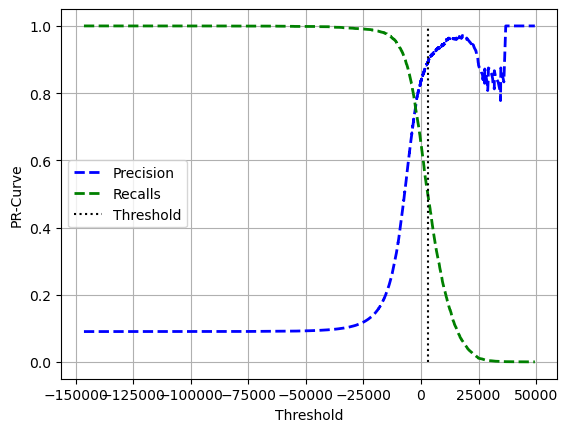

In [24]:
#With the above scores we use the precision_recall_curve function to compute P and R values for all possible thresholds 
# the functions adds a last precision of 0 and last recall of 1 corresponding to infinite threshold 
from sklearn.metrics import precision_recall_curve
pre,rec,thresholds= precision_recall_curve(y_train_5,y_scores)
threshold=3000
plt.plot(thresholds,pre[:-1],"b--",label="Precision",linewidth=2) 
plt.plot(thresholds,rec[:-1],"g--",label="Recalls",linewidth=2) 
plt.vlines(threshold,0,1.0,"k","dotted",label="Threshold") 
plt.legend()
plt.grid(True)
plt.xlabel("Threshold")
plt.ylabel("PR-Curve")
#this graph will show the relation between the precision and recall with changing threshold and allows for best selections

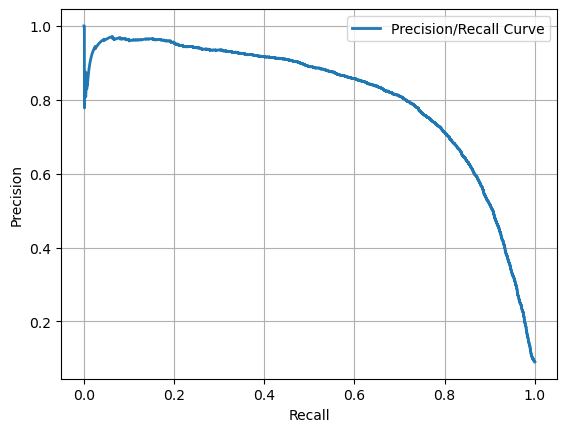

In [25]:
#Another way is to plot  precision directly against recall 
plt.plot(rec,pre,linewidth=2,label="Precision/Recall Curve")
plt.grid(True)
plt.ylabel("Precision")      
plt.xlabel("Recall")      
plt.legend()

In [26]:
#As shown by the graph the precision drops very steeply after 60% of recall
#So to get the exact point where atleast precision =90% for the threshold 

idx_for_90_precision= (pre >= 0.90) .argmax() #gives the first index of maximum value (where the condition becomes true for the first time )
threshold_for_90_precsion= thresholds[idx_for_90_precision]
threshold_for_90_precsion # first index at precision >90%

3370.0194991439594

In [27]:
#to make prediction based on this precsion we use 
y_train_pred_90= (y_scores>= threshold_for_90_precsion)
print(precision_score(y_train_5,y_train_pred_90))
#this shows that any amount of precision can be achieved just by changing the threshold but this costs us the recall 
recall_at_90_precision= recall_score(y_train_5,y_train_pred_90)
print(recall_at_90_precision)
#A recall value of 48 is not optimal 

0.9000345901072293
0.4799852425751706


In [28]:
#The ROC curve
#Reciever operating characteristic is a tool used with binary classifiers simislar to precision/recall curve
#This one plots Recall(aka True positive rate ) against Fallout(False positive rate : The ration of negative instances that are incorrectly classified as positives )
# Specificity or TNR(True Negative Rate) which is the ration of negative instances that are  correctly classified as negative 
#Here ROC plots sensitivity(recall) vs 1-specificity
from sklearn.metrics import roc_curve
fpr,tpr,thresholds= roc_curve(y_train_5,y_scores) #To compute this graph we first need to calc the TPR and FPR for various threshold values 




Text(0.1, 0.8, 'Higher Threshold')

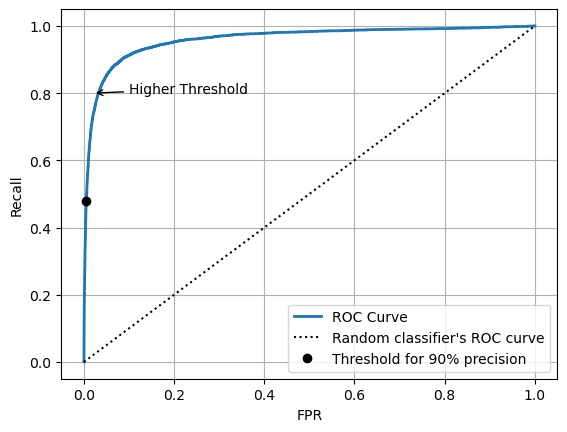

In [29]:
#ploting tpr and Fpr using matplot lib
idx_for_threshold_at_90= (thresholds <= threshold_for_90_precsion).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90],fpr[idx_for_threshold_at_90]

plt.plot(fpr,tpr,linewidth=2,label= "ROC Curve")
plt.plot([0,1],[0,1],"k:",label="Random classifier's ROC curve")
plt.plot([fpr_90],[tpr_90],"ko",label="Threshold for 90% precision")
plt.grid(True)
plt.ylabel("Recall")
plt.xlabel("FPR")
plt.legend()
plt.annotate("Higher Threshold",xy=(0.02,0.8),xytext=(0.1,0.8),arrowprops=dict(arrowstyle="->"))

In [30]:
#once again there is a tradeoff : Higher the TPR(recall) greater the FPR
# The dotted line represents the ROC of a purely random classifier :  a good classifier stays as far away as possible towards a the top left corner 
# One way to compare classifiers is to measure area under the curve(AUC) : A perfect classifier will have ROC AUC = 1
# where as a purely random classifier will have ROC AUC =0.5

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)


0.9604938554008616


    
    As a rule of thumb always prefer a PR curve whenever the positive class is rare or when we care more about the false positives than false negative .other wise use the ROC curve 

In [ ]:
#Now for us to compare the the usefulness of the SDGClassifier we use the Randomforest classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
# Unlike the SGDclassifier , Random forest doesnt have a decision_function() 
#that can provide labels and scores for each of the instances in the datasets
# This is a requirement for the PRECISION_RECALL_CURVE  
# But what random forest does have is a "predict_proba()" method in its class
#  this is similar to decions function but instead this provides a probability for each of the instances
#we can just use the probability of the positive class as a score 


In [33]:
#calling cross_val_predict() function to train RFC
y_probas_forest= cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [ ]:
#checking probability for the first 2 images 
y_probas_forest[:2]
#Predicts first image to be a positive with 89% probability while 2nd it take 90% to be negative
#The second column contains the estimated probabilites for the positive class 

array([[0.11, 0.89],
       [0.99, 0.01]])

In [36]:
#Passing the second column values into precision_recall_curve()
y_scores_forest=y_probas_forest[:,1]
precisions_forest,recalls_forest,thresholds_forest = precision_recall_curve(y_train_5,y_scores_forest)


Text(0.5, 1.0, "This shows that RandomForest Classifier's PR curve is better that SDG's")

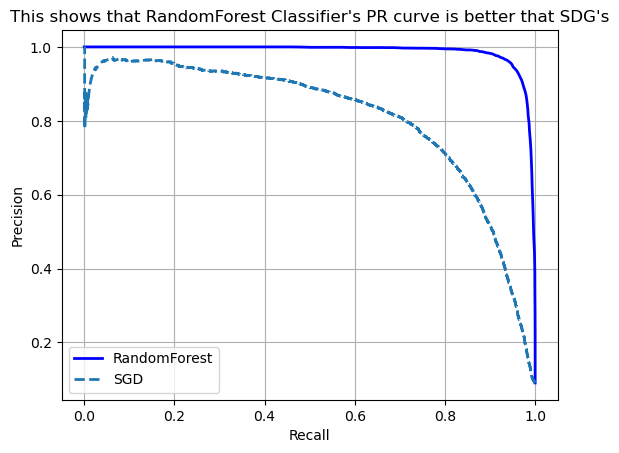

In [40]:
#Making the pr curve
plt.plot(recalls_forest,precisions_forest,"b-",linewidth=2,label="RandomForest")
plt.plot(rec,pre,"--",linewidth=2,label="SGD")
plt.grid(True)
plt.legend()
plt.ylabel("Precision") 
plt.xlabel("Recall")

plt.title("This shows that RandomForest Classifier's PR curve is better that SDG's")

In [41]:
#As the RandomForest's Curve comes much closer to the upper right corner 
# its F1-score and ROC AUC socres are also significantly better
y_train_pred_forest=y_probas_forest[:,1] >=0.5
print(f"The F1 Score of RandomForest Classifier is  :{f1_score(y_train_5,y_train_pred_forest)}")
print(f"The ROC AUC Score of RandomForest Classifier is  :{roc_auc_score(y_train_5,y_train_pred_forest)}")

The F1 Score of RandomForest Classifier is  :0.9274509803921569
The ROC AUC Score of RandomForest Classifier is  :0.9358174809192218


In [42]:
#at the same time the precsion and recall values are
print(f"The Precision Score of RandomForest Classifier is  :{precision_score(y_train_5,y_train_pred_forest)}")
print(f"The Recall Score of RandomForest Classifier is  :{recall_score(y_train_5,y_train_pred_forest)}")

The Precision Score of RandomForest Classifier is  :0.9897468089558485
The Recall Score of RandomForest Classifier is  :0.8725327430363402


SO Far these are just the binary classifiers and for the we
1. chose the appropriate metrics for the task
2. evaluate our classifiers using cross-validation 
3. select the precision/recall tradeoff that fits the needs
and 
4. use several metrics and curves to compare various models 

    MULTICLASS Classification
whereas the binary classifiers can only distinguish between 2 classes the multiclass classifiers (aka multinomial classifiers) can distinguish among more that 2 classes

some SKlearn classifiers are
1. capable of handling multiple classes natively (RandomForest,LogisticRegression)
2. some are also strict binary classifers (eg SGDclassifiers and SVC)

Solving the problem of Digit classification there are 2 main strategies while using only binary classifiers:
1.   One-versus-the-rest/one-versus-all :

 Create a system with 10 separate binary classifiers(one for each digit) then pick the highest value out of them 

 Preffered for most binary classifiers

2.  One-versus-One:
Create and train a binary classifier for every pair of digits . The problem with this being that it will take
                 N*(N-1)/2
    operations to complete a simple task with just 10 tyoes of possibilities
Its mainly used in image classification where we have to see which image wins the most duels 

    Advantage

The one advantage of such system is that each classifier only needs to be trained on tge part of the training set containing the two classes that it must distinguish


For algorithms like Support Vector machines that scale poorly with the size of the training data
this type of approach is much more suited


In [46]:
#using the Support Vector machine classifier to prove a point
from sklearn.svm import SVC

In [48]:
svm_clf=SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000])#taking only the first 2000 inputs due to poor scaling


SVC(random_state=42)

In [49]:
print(svm_clf.predict([digit]))

['2']


In [ ]:
digit_scores= svm_clf.decision_function([digit])
print(f"Round 1: {digit_scores.round(1)}")
print(f"Round 2: {digit_scores.round(2)}")
print(f"Round 3: {digit_scores.round(3)}")

Round 1: [[ 2.8  4.8  9.3  7.3 -0.3  5.8  2.8  0.7  8.3  2.7]]
Round 2: [[ 2.76  4.79  9.31  7.27 -0.29  5.79  2.75  0.73  8.3   2.74]]
Round 3: [[ 2.758  4.788  9.307  7.269 -0.291  5.791  2.752  0.727  8.295  2.745]]
2


In [58]:
#Check Corrospondance to data
class_id= digit_scores.argmax()
print(class_id)

#Better way (As Minst starts with 0 just like normal list indexing)
svm_clf.classes_
svm_clf.classes_[class_id]

2


'2'

In [60]:
#Also if we want we can actually force SKlearn to use OnevOne or OnevRest models manually
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000],y_train[:2000])



OneVsRestClassifier(estimator=SVC(random_state=42))

In [63]:
#Predictions made by the onevrest classification systems"
print(ovr_clf.predict([digit]))
print(len(ovr_clf.estimators_))

['2']
10


In [65]:
sgd_clf= sdg(random_state=43)
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([digit])


array(['2'], dtype='<U1')

In [ ]:
#This is an error and this is because the model is not much confident about its predictions as shown below where
# we can see the that now due to the ovr strategy trains 10 binary classifiers and the decision_function returns one value per class

sgd_clf.decision_function([digit]).round()


array([[-50821., -15994.,   5182.,  -3461., -35466., -11635., -18320.,
        -21264.,  -1612., -17735.]])

In [ ]:
#to counter this lack of confidence we use cross-validations
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")
#As seen this gives and accuracy of about 87% on all test folds 
#We can use a random classifier but that will only reach 10%


array([0.8702 , 0.88485, 0.88725])

In [ ]:
#Scaling the input data to get better accuracy
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
X_train_scaled =  scalar.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")